# Assignment 3


1. Implement linear regression model for multiclass classification using pytorch.  
1. Implement multinomial and one-vs-rest variants on multiclass classification.
1. Implement L2 relularization for your model.  
1. Test your model on 20newsgroups dataset. Your baseline is accuracy=0.75. 
1. How can we justify using accuracy score for this problem?
1. What is acuraccy score for random answer for this problem?

Follow #TODO in the code below.   
Feel free to add additional regularizers to your model.  
Remember, that SGD convergence is slower that lbfgs from scikit-learn. Manage your time. 


Usefull links:  
1. https://pytorch.org/
1. https://gluon.mxnet.io/chapter06_optimization/gd-sgd-scratch.html
1. (bonus) http://ruder.io/optimizing-gradient-descent/


In [1]:
import torch as  tt
from torch.optim import SGD
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import sparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import normalize

%matplotlib inline

SEED = 42
np.random.seed(SEED)


In [2]:
from sklearn.externals import joblib 
import numpy as np
import torch
import math
from copy import copy
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

data = joblib.load('train.data')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

X = data['data']
y = data['target']

In [45]:
class LogisticRegressionNN(nn.Module):
    """
    All neural networks in pytorch are descendants of nn.Module class
    As you remember, Logistic regression is just a 1-layer neural network
    #TODO implement multinomial logistic regression
    """
    
    def __init__(self, d, k):
        """
        In the constructor we define model weights and layers
        d: feature size
        k: number of classes
        """
        super(LogisticRegressionNN, self).__init__()
        
        # TODO create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) using np.random.rand
        # W has shape (d,k)
        # b has shape (d,)
        # set requires_grad=True for tensors, so they can be learned during training
        self.W = tt.tensor(np.random.rand(d, k), requires_grad=True, dtype=torch.float32)
        self.b = tt.tensor(np.random.rand(k), requires_grad=True, dtype=torch.float32)

    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # TODO implement linear model without softmax
        result = torch.add(torch.mm(x, self.W), self.b)
        return result
    
    def parameters(self):
        """
        learnable model parameters
        """
        return [self.W, self.b]
    
    
class LogisticRegressionEstimator(BaseEstimator, ClassifierMixin):
    """
    Logistic Regression estimator coping interface from scikit-learn
    """
    def __init__(self, learning_rate=0.2, n_epochs=50, batch_size=100, alpha=1, multi_class='multinomial', verbose=False):
        """
        learning_rate: SGD learning rate
        n_epochs: number of epochs
        batch_size: size of mini-batch
        alpha:  regularizer coef
        multi_class: ['multinomial', 'ovr']
        verbose:
        """
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.multi_class = multi_class
        self.verbose = verbose
        self.model_nn = None
        self.batch_size = batch_size
        
    def _train_nn(self, model, X, y):
        """
        Train neural network
        model: neural network module
        X: - feature matrix
        y: - target values
        """
        
        criterion = nn.CrossEntropyLoss()
        optimizer = tt.optim.SGD(model.parameters(), lr=self.learning_rate)
        n_batches = math.ceil(X.shape[0] / self.batch_size)

        if self.verbose:
            t_epochs = tqdm_notebook(range(self.n_epochs), desc='epochs', leave=True)
        else:
            t_epochs = range(self.n_epochs)

        if sparse.issparse(X):
            x_dense = scipy.sparse.csr_matrix.todense(X)
        elif isinstance(X, np.ndarray):
            x_dense = X
        else:
            raise ValueError('X must be np.array or sparse')
            
        for epoch in t_epochs:

            indices = np.random.choice(list(range(X.shape[0])), size=X.shape[0])
            
            epoch_average_loss = 0

            for j in range(n_batches):

                batch_idx = indices[j: j + self.batch_size]

                batch_x = torch.from_numpy(x_dense.take(batch_idx, axis=0)).float() # X должен быть np
                batch_y = torch.from_numpy(np.array(y).take(batch_idx)).long() 
                
                optimizer.zero_grad()
                pred = model.forward(batch_x)
                
                loss = criterion(pred, batch_y)

                weights = model.parameters()[0]
                # alpha/2 * tt.norm(model.W)**2
                loss += self.alpha/2 * torch.norm(weights)**2                 

                loss.backward()
                optimizer.step()

                epoch_average_loss += loss.data.detach().item()
            
            epoch_average_loss /= n_batches
            if self.verbose:
                t_epochs.set_postfix(loss='%.3f' % epoch_average_loss)
        
        
    def fit(self, X, y):
        """
        X: feature matrix
        y: target values
        """
        
        n_features = X.shape[1]
        self.n_classes_ = len(np.unique(y))
        self.label_encoder_ = LabelEncoder()
        self.label_binarizer_ = LabelBinarizer(sparse_output=True)
        
        # binary classification
        if self.n_classes_ == 2:
            y = self.label_encoder_.fit_transform(y)
            self.model_nn = LogisticRegressionNN(n_features, 2)
            self._train_nn(self.model_nn, X, y)
            
        else:
            
            if self.multi_class == 'multinomial':
                y = self.label_encoder_.fit_transform(y)
                self.model_nn = LogisticRegressionNN(n_features, self.n_classes_)
                self._train_nn(self.model_nn, X, y)
    
    
            # ovr classification
            elif self.multi_class == 'ovr':
                
                if self.verbose:
                    t_ovr = tqdm_notebook(range(self.n_classes_), desc='ovr')
                else:
                    t_ovr = range(self.n_classes_)

                Y = self.label_binarizer_.fit_transform(y)
                Y = Y.tocsc()
               # classes_ = self.label_binarizer_.classes_
                columns = (col.toarray().ravel() for col in Y.T)
                self.models = []

                for index, y_ovr in enumerate(columns):
                    self.model_nn = LogisticRegressionNN(n_features, 2)
                    self._train_nn(self.model_nn, X, y_ovr)
                    self.models.append(self.model_nn)

        return self
                    
    def predict_proba(self, X):
        
        if sparse.issparse(X):
            x_dense = scipy.sparse.csr_matrix.todense(X)
            X = tt.from_numpy(x_dense).float()
        elif isinstance(X, np.ndarray):
            X =  tt.from_numpy(X).float()
        else:
            raise ValueError('X must be np.array or sparse')
        
        
        if self.n_classes_ == 2:
            pred = self.model_nn.forward(X)
            pred = tt.softmax(pred, dim=-1)
            pred = pred.detach().numpy()
            return pred
            
        else:
            if self.multi_class == 'multinomial':
                # TODO return class probabilities
                pred = self.model_nn.forward(X)
                pred = tt.softmax(pred, dim=-1)
                pred = pred.detach().numpy()
                return pred
                
            elif self.multi_class == 'ovr':
      
                res = []
                
                for est in self.models:
                    pred = est.forward(X)
                    pred = tt.sigmoid(pred)
                    pred = pred.detach().numpy()
                    res.append(pred[:, 1])
                
                res = np.array(res).T
                #res /= np.sum(res, axis=1)[:, np.newaxis] 
                res = normalize(res)
                return res
            
    def predict(self, X):
        proba = self.predict_proba(X)
        return proba.argmax(axis=1)

In [4]:
tf = TfidfVectorizer(max_features=9109, stop_words='english')
X_train = tf.fit_transform(X)
X_train.shape

(11314, 9109)

In [5]:
data_test = joblib.load('test.data')

In [6]:
X_test = tf.transform(data_test['data'])
y_test = data_test['target']

In [7]:
X_test.shape

(7532, 9109)

In [75]:
def grid_param(learning_rate=0.2, n_epochs=50, batch_size=100, alpha=1, multi_class='multinomial', verbose=True):
    
    est = LogisticRegressionEstimator(learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, alpha=alpha, multi_class=multi_class, verbose=verbose)
    
    global X_train, y, X_test, y_test
    est.fit(X_train, y)
    y_pred = est.predict(X_test)
    return 'acc' + ': ' + str(metrics.accuracy_score(y_test, y_pred))

Грид серч в другом ноутбуке (тоже выложила) работал слишком долго (ночь и весь день, и так и не доработал), поэтому я решила сама постепенно перебирать пар-ры, отталкиваясь от того, что хорошо работает

### Multinomial

In [59]:
grid_param(learning_rate=0.2, n_epochs=5, batch_size=2000, alpha=0.1, multi_class='multinomial')

'acc: 0.053372278279341476'

In [60]:
grid_param(learning_rate=0.3, n_epochs=10, batch_size=2000, alpha=0.001, multi_class='multinomial')

'acc: 0.050982474774296335'

In [61]:
grid_param(learning_rate=0.3, n_epochs=50, batch_size=2000, alpha=0.001, multi_class='multinomial')

'acc: 0.10183218268720128'

In [62]:
grid_param(learning_rate=0.3, n_epochs=80, batch_size=2000, alpha=0.001, multi_class='multinomial')

'acc: 0.1526818906001062'

In [55]:
grid_param(learning_rate=0.3, n_epochs=50, batch_size=2000, alpha=0.0001, multi_class='multinomial')

'acc: 0.11258629845990441'

In [73]:
grid_param(learning_rate=0.3, n_epochs=100, batch_size=2000, alpha=0.0001, multi_class='multinomial')

'acc: 0.1775092936802974'

In [74]:
grid_param(learning_rate=0.3, n_epochs=500, batch_size=2000, alpha=0.0001, multi_class='multinomial')

'acc: 0.6072756240042485'

In [76]:
grid_param(learning_rate=0.3, n_epochs=1000, batch_size=2000, alpha=0.0001, multi_class='multinomial')

'acc: 0.7270313329792883'

In [57]:
grid_param(learning_rate=0.3, n_epochs=2000, batch_size=2000, alpha=0.0001, multi_class='multinomial')

'acc: 0.7736325013276686'

Видимо, с ростом кол-ва эпох можно достигнуть более высого результата.

#### Best params - learning_rate=0.3, n_epochs=2000, batch_size=2000, alpha=0.0001

#### Best accuracy - 0.77

### OVR

In [72]:
grid_params(learning_rate=0.3, n_epochs=50, batch_size=2000, alpha=0.0001, multi_class='ovr')

'acc: 0.096388741370154'

In [ ]:
grid_param(learning_rate=0.3, n_epochs=100, batch_size=2000, alpha=0.0001, multi_class='ovr', verbose=False)

Не успеваю подобрать лучшие пар-ры к ovr, слишком долго работает

### How can we justify using accuracy score for this problem?

Accuracy мы можем использовать тогда, когда у нас классы в выборке сбалансированы, потому что, например, если у нас одного класса 99% данных, а другого 1%, мы можем просто всем давать лейбл первого класса и получать accuracy 99%

In [19]:
import collections

In [58]:
a = collections.Counter(y)

Text(0,0.5,'Frequency')

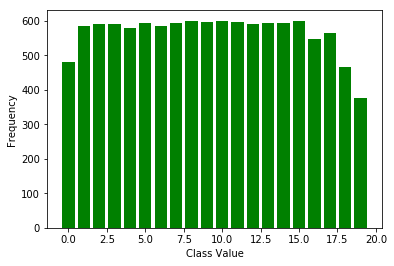

In [71]:
import matplotlib.pyplot as plt

plt.bar(a.keys(), a.values(), color='g')
plt.xlabel('Class Value')
plt.ylabel('Frequency')

Как видно на приведенных данных, лейблы достаточно равномерно распределены

### What is acuraccy score for random answer for this problem?


In [68]:
est = LogisticRegressionEstimator(learning_rate=0.1, n_epochs=5, batch_size=1000, alpha=1, multi_class='multinomial')
est.fit(X_train, y)
y_pred = est.predict(X_test)
print('acc', metrics.accuracy_score(y_test, y_pred))

acc 0.05284121083377589


Эстиматор с рандомным параметрами работает очень плохо: скор соответсвует случайному попаданию в класс, с таким же успехом мы могли просто присваивать всем один и тот же класс.

In [69]:
print('acc', metrics.accuracy_score(y_test, [1]*len(y_test)))

acc 0.05164630908125332
